<a href="https://colab.research.google.com/github/mdh266/TextClassificationApp/blob/feature%2Fkeras/NLP_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification 4: Deep Learning With Tensorflow and Optuna
--------------

__[1. Introduction](#first-bullet)__

__[2. Vectorizing Text](#second-bullet)__

__[3. Handling Imbalance In The Data](#third-bullet)__

__[4. Building A Convolutional Neural Network With Keras](#fourth-bullet)__

__[5. Hyper-parameter Tuning with Optuna](#fifth-bullet)__

__[6. Conclusions](#sixth-bullet)__


## Introduction <a class="anchor" id="first-bullet"></a>
------------------

In this post I want to extend on the last [model](http://michael-harmon.com/blog/NLP2.html) in my blog series on text classification where I used a SVM to predict the topic of papers in arxiv based on their abstract. For reference the topics were "Machine Learning", "Computer Vision", "Artifical Intelligence" and "Robotics" and there was imbalance in the classes.

In this post I will use a [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) model with [Tensorflow](https://www.tensorflow.org/) and [Keras](https://keras.io/) to predict the topic of the abstract and use [Optuna](https://optuna.org/) to optimize the hyperparamters of the model. Keras is a high level library that makes building complex deep learning models relatively easy as well as being built into [Tensorflow](https://www.tensorflow.org/) which is a production ready framework. Optuna is powerful automatic hyperparameter tuning library that uses a *define-by-run* design that makes it elegant and easy to use. I have just started using this library and have been particularly impressed with the design and felt it was extremely intuitve. While CNN's are no longer the state-of-the-art algorithms for text classification, they still perform quite well and I wanted to explore how they would work on this problem.

Before we get started building the model let's quickly go over vectorizing text as the process I use in this post is different from prior posts which used the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model).

## Vectorizing Text <a class="anchor" id="second-bullet"></a>

Machine learning models make use of numerical data in the form of vectors that represent the values of the features in the model. The model is really just an approximation to a function that maps the input vectors to the output (which can be a scalar or vector). In order to build machine learning models that use text data we need convert the text to numerical vectors. To do this we use a [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model) which repesents words as vectors in the space.

In my [first post](http://michael-harmon.com/blog/NLP1.html) in this series I went over a vector space model called  [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) along with [Term Frequency-Inverse Document Frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). While these are a classic representations for text, one pifull is that is often produces sparse high dimensional representations. This combination can be particularly challenging for machine learning models to work with. Another shortcoming of the bag-of-words model is that it doesn not take into account order of the words or their semantic relationships. We'll address is the issue of semantic relationships using [Word Embeddings](https://en.wikipedia.org/wiki/Word_embedding), but first we need to discuss how to vectorize text using the TensorFlow [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class.  

First let's grab our data from [Google Cloud Storage](https://cloud.google.com/storage) using [Pandas](https://pandas.pydata.org/) where is stored as json objects. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_json("gs://harmon-arxiv/train_abstracts.json")
test_df  = pd.read_json("gs://harmon-arxiv/test_abstracts.json")

train_df.head()

,category,text
0,ai,Because of their occasional need to return to ...
1,ai,Market price systems constitute a well-underst...
2,ai,We describe an extensive study of search in GS...
3,ai,As real logic programmers normally use cut (!)...
4,ai,To support the goal of allowing users to recor...


Let's convert the category to numerical values 1, 2, 3, 4 which represent the different abstract topics using the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) function:

In [2]:
from sklearn.preprocessing import LabelEncoder

labeler  = LabelEncoder()
train_df = train_df.assign(target=labeler.fit_transform(train_df["category"]))
test_df  = test_df.assign(target=labeler.fit_transform(test_df["category"]))

train_df.head()

,category,text,target
0,ai,Because of their occasional need to return to ...,0
1,ai,Market price systems constitute a well-underst...,0
2,ai,We describe an extensive study of search in GS...,0
3,ai,As real logic programmers normally use cut (!)...,0
4,ai,To support the goal of allowing users to recor...,0


Now just like with bag-of-words model we need to reperesent documents as vectors in a vector space.  We use the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class to automatically convert documents to vectors. This class creates a dictionary of words where each word is associated number with an integer index in the dictionary. Words in the sentences are represented by their index value in the vector. The order of the words in the sentence dictate which entry they are in the vector. For example the first word in the sentence has it index value in entry 0 in the vector, the second word has its index value in entry 1 in the vector and so on.

We cap the number of words in our dictionary (or vocabulary) at an integer called `max_tokens`. We also set the length of sentences to be capped at `sequence_length` tokens long. That means if our abstract contains less than `sequence_length` words then we pad the rest of the vectors entries with 0's to give it a length of `sequence_length`. If the abstract contains more than `sequence_length` words it will be cut short.

Let's first set `sequence_length` by looking at the number of tokens in each document by their category in a histogram:

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

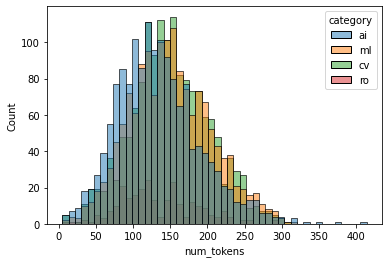

In [3]:
import seaborn as sns

train_df = train_df.assign(num_tokens=train_df.text.str.split().apply(len))

sns.histplot(data=train_df, x="num_tokens", hue="category")

We can see that most documents are between 50 and 250 words long and the max is a little over 400. So let's set our max sequence length to be 400. 

Now, we'll import Tensorflow as well as TextVectorization function. Note the version of TensorFlow I am using is 

In [4]:
import tensorflow as tf
tf.__version__

'2.8.0'

Depending on your verion of Tensorflow, [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) (along with other functions I use) may no longer be experimental and the path may be different.

We create a `TextVectorization` layer that has a max sequence length of 400 and cap the vocabulary to be 20,000. Words that are not in this vocabulary will be set to a default "unknown" token. 

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 20000
sequence_length = 400

vectorize_layer = TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode="int",
    pad_to_max_tokens=True,
    output_sequence_length=sequence_length,
)

Metal device set to: Apple M1


2022-10-10 20:47:41.369111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 20:47:41.369582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Now we train the layer on the entire training dataset,

In [6]:
vectorize_layer.adapt(train_df["text"].to_numpy())

2022-10-10 20:47:46.501156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-10 20:47:46.548039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Let's look at an example of a text and its vector representation,

In [7]:
test = train_df["text"][0]
test

'Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.'

Now lets look at the vector representation,

In [81]:
vectorize_layer.call(test)

<tf.Tensor: shape=(400,), dtype=int64, numpy=
array([ 348,    3,   80,    1,  408,    6, 2380,    6, 2802,  244,    7,
          4,  106,  345,  124, 2220,   39,   22, 2119,    1, 1526, 1510,
       2481,  316,    4,  106,   33,    7,   12,   24,    9,   65,    4,
         29,   18,   20, 5380,  244,   22,   19, 6762, 2778,    7,    2,
        106,   98, 1666, 2529,   12, 1307,    2,  147,  241,    8,    4,
       1115,    3,    1, 2220,   11,  303,   95,  568,   98,  123,  619,
        993,  396,  205,   53,    5, 3918,    2, 2471,  809,  538,   18,
       1609,  127,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

Note that our vectors are of max sequence length (400), not the vocabulary length (20,000). Since the above sentence did not have 400 words in it, we pad vector with 0's to make sure the vectors are all of the same length.

The i-th entry in the above vector corresponds to the i-th word in sequence of words in the text. The value of the entry in the vector is the index for that word in our vocabulary.

The first entry is 348 which means that the word "because" is the entry 348 in our 20,000 vocabulary list. The second entry is 3, which means the word "of" is the 3rd entry in our vocabulary list.

Let's try a word that most likely isnt on our vocabulary to see what the default token's entry is in our vocabulary list

In [8]:
vectorize_layer.call("onomatopoeia triglycerides")

<tf.Tensor: shape=(400,), dtype=int64, numpy=
array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

We can see that the word "onomatopeoia" and "triglycerides" are both represented by a 1 which means the unknown token in our vocabulary is 1. We can get the dictionary of words by using the `.get_vocabulary` method.

In [9]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## Handling Imbalance In The Data <a class="anchor" id="third-bullet"></a>

I found the most natural way to deal with imbalanced data in Keras is using weights, similar to the way I did in the [first blog post](http://michael-harmon.com/blog/NLP1.html) in this series. In other frameworks like [Scikit-Learn](https://scikit-learn.org/stable/) the weights for each class are determined automatically, however, with Kera's I found I neeeded to set them explicitly.

Luckily we can use Scikit-Learn's [compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function to get estimates for the weights,

In [10]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
                                   'balanced',
                                    classes= np.unique(train_df["target"]), 
                                    y=train_df["target"])

print(f"class_weights: {class_weights}")

class_weights: [0.79084967 0.79084967 0.79084967 4.84      ]


Then we can convert that into a dictionary for each class and its corresponding weight:

In [11]:
weights_dict = dict(zip(range(4), class_weights))
print(f"weights_dict: {weights_dict}")

weights_dict: {0: 0.7908496732026143, 1: 0.7908496732026143, 2: 0.7908496732026143, 3: 4.84}


We're cheating a little here because were using the entire dataset for calculating the dataset, but we wont be using cross validation so it's not so bad.

Let's take a look at the data again, but this time look at distribution of the target variable with respect to the index in the dataframe

<AxesSubplot:xlabel='index', ylabel='target'>

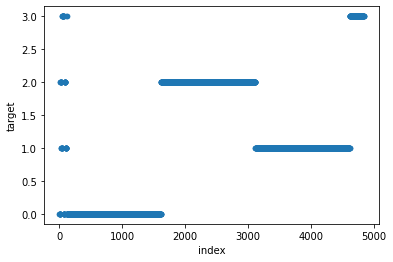

In [12]:
train_df.reset_index().plot('index', 'target', kind='scatter')

The dataset is ordered by the target variable which can be a problem for deep learning models. Deep learning models use [mini-batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) which use small batches of the original dataset to train on instead of the entire dataset. If the data is ordered according to the target variable each batch most likely will only have data from one class making the model unable to discern differences between classes.

To avoid this situation we want to shuffle the dataset first so that the model will get a sufficient representation of  each class in each batch during training.

In [13]:
from sklearn.utils import shuffle

shuff_train_df = shuffle(train_df)
shuff_test_df = shuffle(test_df)

We can now see the datset is not ordered by the target variable value,

<AxesSubplot:xlabel='index', ylabel='target'>

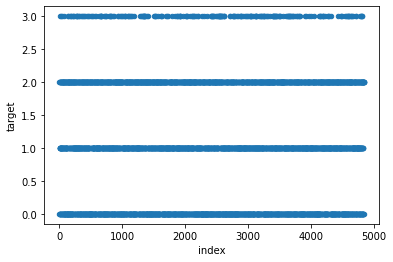

In [14]:
(shuff_train_df.reset_index(drop=True)
               .reset_index()
               .plot('index', 'target', kind='scatter'))

Now the data looks much more evenly distributed across the index of the dataframe!

Notice that I didnt have to worry about this in prior blog post's models since Scikit-Learn by default uses statified sampling to create folds in [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Those prior models also train on the entire fold in cross-validation.

Lastly before we get started with the building a model we one-hot encode the target classes using the [label_binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html) function:

In [15]:
from sklearn.preprocessing import label_binarize

# classes = [0,1,2,3]
classes   = np.sort(train_df["target"].unique())

# relabel the test set
y_train = label_binarize(train_df["target"],
                         classes=classes)

y_test = label_binarize(test_df["target"], 
                        classes=classes)

We can see that the results are a 4-dimensional vector,

In [16]:
y_train[0]

array([1, 0, 0, 0])

Now we can move onto building a convolutional neural network using Keras!

## Building A Convolutional Neural Network With Keras <a class="anchor" id="fourth-bullet"></a>

We will use a [Convolution Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) with the architecture shown below,

<figure>
<img src="images/Basic-architecture-of-CNN.png" alt="Trulli" style="width:75%">
<figcaption align = "center">
    <b>From https://www.researchgate.net/figure/Basic-architecture-of-CNN_fig3_335086346</b>
</figcaption>
</figure>

This is a pretty classic architecture for text classification that uses two [1D Convolutional Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with an [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [1D MaxPooling Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool1D). This is followed by a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and a [softmax layer](https://en.wikipedia.org/wiki/Softmax_function) for predicting one of the four classes. The one thing that the above diagram does show is that Input Layer is using an [Embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) followed by a Dropout layer.

[Word Emeddings](https://en.wikipedia.org/wiki/Word_embedding) (or embeddings) allows us to represent words in a dense low-dimensional vector space instead of a high-dimensional sparse vector space as with the bag-of-words model. In addition to reducing dimensionality they also allow us to learn semantic relationship between words.

A more detailed look at the convolutional/max pooling block is shown below, 

<figure>
<img src="images/1d-convolutional.jpg" alt="Trulli" style="width:75%">
<figcaption align = "center">
    <b>From https://www.researchgate.net/figure/a-Simple-scheme-of-a-one-dimension-1D-convolutional-operation-b-Full_fig2_334609713</b>
</figcaption>
</figure>

A convolutional layer is made up filters (or kernels) that have weights that must be learned. The kernel size is the number of weights in each filter and are shown in pink. We take the sum-product of the weights and entries in the input vector and apply an [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) to form new entries in a the output layer. We slide this filter over all windows of size kernel size in the input layer to fill out entries in the output layer (yellow square). In this slidding mechanism we skip entries in the input space. The number of entries that we skip is called the [stride size](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/). This process process is called a convolution and results in an output that has less dimensions than input. We can supress this reduction in dimension by [padding](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/) the input vector with 0's so that the output is the same size as the input. Allowing the output space to be reduced in dimension is called "valid" padding and supressing this is called "same" padding.

The [max pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) looks at the values in a window of the convolutions output layer and finds the maximum value and makes that the value in the output cell. Another version of the operation is shown below.

<figure>
<img src="images/1D-max-pooling-operation.png" alt="Trulli" style="width:75%">
<figcaption align = "center">
    <b>From https://www.researchgate.net/figure/1D-max-pooling-operation_fig4_324177888</b>
</figcaption>
</figure>



The window size is again called the `pool_size` (`pooling_size` as labeled above).  MaxPooling also has the concept of `stride` and `padding` that a convolutional layer does. The point of MaxPooling is to make the repesentation more invariant to transformations, a concept that is more intuitive for me when it comes to computer vision.

Lastly, we apply [DropOut](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) which is a form of regularization that randomly sets the weights of specific neurons to  zero during training time. This is shown below,

<figure>
<img src="images/dropout.jpg" alt="Trulli" style="width:75%">
<figcaption align = "center">
    <b>From https://wenkangwei.github.io/2020/11/13/DL-DropOut/</b>
</figcaption>
</figure>


Drop out prevents overfittings by making the network not too overly dependent on any one neurons layer.

Now that we have gone over the basics of the CNN architecture let's get building a model!

We can import the necessary modules and see if we are using a GPU for training: 

In [17]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
def build_model(
    embedding_dim: int=64,
    filters: int=32,
    kernel_size: int=5,
    stride_size: int=3,
    conv_padding: str="valid",
    pool_padding: str="same",
    dropout: float=0.2
) -> Sequential:
    
    model = Sequential([
                # Embedding Layer
                tf.keras.Input(shape=(1,), 
                               dtype=tf.string, 
                               name='text'),
                vectorize_layer,
                layers.Embedding(max_features, embedding_dim),
                layers.Dropout(dropout),

                # Convolutional Layers
                layers.Conv1D(filters, 
                              kernel_size, 
                              padding=conv_padding, 
                              activation="relu", 
                              strides=stride_size),
        
                layers.MaxPooling1D(padding=pool_padding),
        
                layers.Conv1D(filters, 
                              kernel_size, 
                              padding=conv_padding, 
                              activation="relu", 
                              strides=stride_size),
        
                layers.GlobalMaxPool1D(),

                # Add a vanilla hidden layer:
                layers.Dense(filters, activation="relu"),
                layers.Dropout(dropout),

                # softmax layer
                layers.Dense(4, activation="softmax")
    ])

    # sceduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate=1e-2,
                            decay_steps=1000,
                            decay_rate=0.2)
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                  metrics=["accuracy", tf.keras.metrics.AUC(name='prc', curve='PR')])

    return model

We can now build the model and see the number of unknowns in each layer using the summary method,

In [94]:
model = build_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 400)              0         
 torization)                                                     
                                                                 
 embedding_11 (Embedding)    (None, 400, 64)           1280000   
                                                                 
 dropout_22 (Dropout)        (None, 400, 64)           0         
                                                                 
 conv1d_22 (Conv1D)          (None, 132, 32)           10272     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 66, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 21, 32)          

Next, we can fit the model using `batch_size = 32` for 10 epochs and applying the weights for each of the classes.

In [95]:
weights_dict[3] = 2

In [96]:
# Fit the model using the train and test datasets.
history = model.fit(train_df["text"], 
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    class_weight=weights_dict, 
                    validation_split=0.2,
                    verbose=False)

2022-10-10 22:01:41.236126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 22:01:45.659041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


We can now plot the learning curves to see how our model is performing,

In [97]:
history_df = pd.DataFrame(history.history)

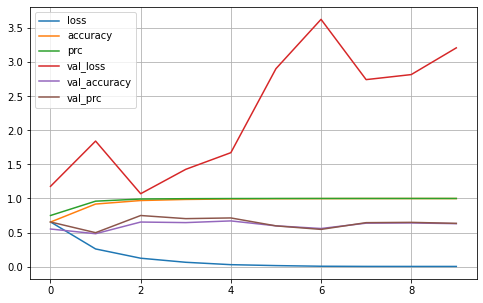

In [98]:
history_df.plot(figsize=(8,5))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()
# plt.legend()

The number of unknowns in this model is dominated by the word embedding. The model has 4 million unknowns which makes it quite quickly complex and the model quickly ovefits to the traning set after 1 epoch! 

Let's take a look at the ROC and Precision-Recall curve,

2022-10-10 22:02:18.536154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


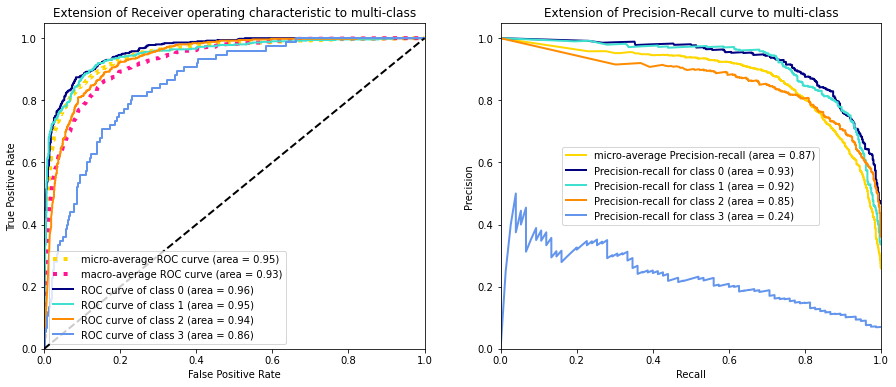

In [99]:
from utils.Plot_ROC_PR_Curve import plot_roc_pr

y_pred = model.predict(test_df["text"])

plot_roc_pr(y_pred = y_pred, y_test = y_test)

The model is performing well on the majority classes, but horribly on the minority class!

Let's see if we can improve this

## Hype-Parameter Tuning with Optuna <a class="anchor" id="fourth-bullet"></a>

In [39]:
import optuna

In [54]:
def objective(trial):
    tf.keras.backend.clear_session()
    
    model = build_model(embedding_dim=trial.suggest_categorical("embedding_dim", [16, 32, 64, 128, 256]),
                        conv_padding=trial.suggest_categorical("conv_padding", ["valid", "same"]),
                        pool_padding=trial.suggest_categorical("pool_padding", ["valid", "same"]),
                        kernel_size=trial.suggest_int("kernel_size", 8, 16, 32, 64),
                        stride_size=trial.suggest_categorical("strides", [2, 3, 5]),
                        dropout=trial.suggest_float("droput", 0.3, 0.7))
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                         restore_best_weights=True)
    
    model.fit(train_df["text"], 
             y_train, 
             epochs=50, 
             batch_size=trial.suggest_categorical("batch_size", [32, 64, 128]), 
             class_weight=weights_dict, 
             validation_split=0.2,
             callbacks=[early_stopping_cb],
             verbose=False)
    
    scores = model.evaluate(test_df["text"], y_test)
    return scores[1]
    

In [55]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=600)

[I 2022-10-02 17:03:38,353] A new study created in memory with name: no-name-ebe58550-ab11-4430-a3a3-bf3a4cfacffa
2022-10-02 17:03:38.794951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:03:42.513644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 11ms/step - loss: 0.6377 - accuracy: 0.7924 - prc: 0.8700


[I 2022-10-02 17:04:22,097] Trial 0 finished with value: 0.7923809885978699 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 7, 'strides': 5, 'droput': 0.43383178163686364, 'batch_size': 32}. Best is trial 0 with value: 0.7923809885978699.
2022-10-02 17:04:22.401016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:04:25.810851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 11ms/step - loss: 0.5618 - accuracy: 0.7949 - prc: 0.8842


[I 2022-10-02 17:05:00,892] Trial 1 finished with value: 0.7949206829071045 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 3, 'strides': 2, 'droput': 0.3802227036710344, 'batch_size': 32}. Best is trial 1 with value: 0.7949206829071045.
2022-10-02 17:05:01.230082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:05:04.569917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 14ms/step - loss: 0.6289 - accuracy: 0.7740 - prc: 0.8660


[I 2022-10-02 17:05:31,390] Trial 2 finished with value: 0.7739682793617249 and parameters: {'embedding_dim': 256, 'conv_padding': 'valid', 'pool_padding': 'valid', 'kernel_size': 5, 'strides': 2, 'droput': 0.4942036350939235, 'batch_size': 128}. Best is trial 1 with value: 0.7949206829071045.
2022-10-02 17:05:31.709819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:05:34.930761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 14ms/step - loss: 0.6839 - accuracy: 0.7644 - prc: 0.8390


[I 2022-10-02 17:06:04,523] Trial 3 finished with value: 0.7644444704055786 and parameters: {'embedding_dim': 256, 'conv_padding': 'valid', 'pool_padding': 'same', 'kernel_size': 7, 'strides': 2, 'droput': 0.6571904181664665, 'batch_size': 128}. Best is trial 1 with value: 0.7949206829071045.
2022-10-02 17:06:04.842581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:06:06.934588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 14ms/step - loss: 0.6068 - accuracy: 0.7981 - prc: 0.8738


[I 2022-10-02 17:06:23,851] Trial 4 finished with value: 0.7980952858924866 and parameters: {'embedding_dim': 64, 'conv_padding': 'valid', 'pool_padding': 'same', 'kernel_size': 5, 'strides': 3, 'droput': 0.5957536783675556, 'batch_size': 128}. Best is trial 4 with value: 0.7980952858924866.
2022-10-02 17:06:24.175637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:06:28.479941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 13ms/step - loss: 0.7642 - accuracy: 0.8083 - prc: 0.8674


[I 2022-10-02 17:07:16,556] Trial 5 finished with value: 0.8082540035247803 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 5, 'strides': 3, 'droput': 0.4198489960330284, 'batch_size': 32}. Best is trial 5 with value: 0.8082540035247803.
2022-10-02 17:07:16.872043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:07:20.208380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 14ms/step - loss: 0.5763 - accuracy: 0.8152 - prc: 0.8830


[I 2022-10-02 17:07:47,453] Trial 6 finished with value: 0.8152381181716919 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 7, 'strides': 2, 'droput': 0.43371043901389245, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:07:47.795105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:07:49.831491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 13ms/step - loss: 0.5531 - accuracy: 0.8114 - prc: 0.8867


[I 2022-10-02 17:08:05,741] Trial 7 finished with value: 0.8114286065101624 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 5, 'strides': 3, 'droput': 0.4226041002436505, 'batch_size': 128}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:08:06.075543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:08:08.461124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 14ms/step - loss: 0.6847 - accuracy: 0.7695 - prc: 0.8419


[I 2022-10-02 17:08:30,261] Trial 8 finished with value: 0.7695238590240479 and parameters: {'embedding_dim': 128, 'conv_padding': 'valid', 'pool_padding': 'valid', 'kernel_size': 3, 'strides': 3, 'droput': 0.4121372547643315, 'batch_size': 128}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:08:30.591277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:08:34.895522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.6113 - accuracy: 0.7981 - prc: 0.8782


[I 2022-10-02 17:09:26,723] Trial 9 finished with value: 0.7980952858924866 and parameters: {'embedding_dim': 256, 'conv_padding': 'valid', 'pool_padding': 'same', 'kernel_size': 7, 'strides': 2, 'droput': 0.5339244995118158, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:09:27.084964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:09:31.366137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 18ms/step - loss: 0.6291 - accuracy: 0.8051 - prc: 0.8738


[I 2022-10-02 17:10:04,281] Trial 10 finished with value: 0.8050794005393982 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 7, 'strides': 5, 'droput': 0.3230437751205056, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:10:04.612404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:10:08.651896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.8013 - accuracy: 0.8006 - prc: 0.8663


[I 2022-10-02 17:10:44,739] Trial 11 finished with value: 0.8006349802017212 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 5, 'strides': 3, 'droput': 0.5118330708808335, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:10:45.059900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:10:48.405841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.7530 - accuracy: 0.7829 - prc: 0.8510


[I 2022-10-02 17:11:21,340] Trial 12 finished with value: 0.7828571796417236 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 3, 'strides': 2, 'droput': 0.30032237342735035, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:11:21.660144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:11:25.119903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.6451 - accuracy: 0.8032 - prc: 0.8745


[I 2022-10-02 17:11:47,070] Trial 13 finished with value: 0.803174614906311 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 5, 'strides': 3, 'droput': 0.4667827263071357, 'batch_size': 128}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:11:47.394247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:11:51.735820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.7915 - accuracy: 0.8083 - prc: 0.8589


[I 2022-10-02 17:12:29,483] Trial 14 finished with value: 0.8082540035247803 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 7, 'strides': 5, 'droput': 0.36439544234336496, 'batch_size': 64}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:12:29.809291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:12:32.528450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.8205 - accuracy: 0.7676 - prc: 0.8564


[I 2022-10-02 17:12:59,568] Trial 15 finished with value: 0.7676190733909607 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 5, 'strides': 2, 'droput': 0.563980917173621, 'batch_size': 128}. Best is trial 6 with value: 0.8152381181716919.
2022-10-02 17:12:59.891975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:13:03.557022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.5437 - accuracy: 0.8241 - prc: 0.8917


[I 2022-10-02 17:13:34,341] Trial 16 finished with value: 0.8241270184516907 and parameters: {'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 7, 'strides': 3, 'droput': 0.4568247271679226, 'batch_size': 64}. Best is trial 16 with value: 0.8241270184516907.
2022-10-02 17:13:34.665391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:13:38.572718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 17ms/step - loss: 0.8858 - accuracy: 0.5854 - prc: 0.7180


[I 2022-10-02 17:14:10,811] Trial 17 finished with value: 0.5853968262672424 and parameters: {'embedding_dim': 128, 'conv_padding': 'same', 'pool_padding': 'same', 'kernel_size': 7, 'strides': 3, 'droput': 0.47087781368122006, 'batch_size': 64}. Best is trial 16 with value: 0.8241270184516907.


In [56]:
best_trial = study.best_trial

In [57]:
best_trial

FrozenTrial(number=16, values=[0.8241270184516907], datetime_start=datetime.datetime(2022, 10, 2, 17, 12, 59, 569120), datetime_complete=datetime.datetime(2022, 10, 2, 17, 13, 34, 341007), params={'embedding_dim': 64, 'conv_padding': 'same', 'pool_padding': 'valid', 'kernel_size': 7, 'strides': 3, 'droput': 0.4568247271679226, 'batch_size': 64}, distributions={'embedding_dim': CategoricalDistribution(choices=(64, 128, 256)), 'conv_padding': CategoricalDistribution(choices=('valid', 'same')), 'pool_padding': CategoricalDistribution(choices=('valid', 'same')), 'kernel_size': IntUniformDistribution(high=7, low=3, step=2), 'strides': CategoricalDistribution(choices=(2, 3, 5)), 'droput': UniformDistribution(high=0.7, low=0.3), 'batch_size': CategoricalDistribution(choices=(32, 64, 128))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=16, state=TrialState.COMPLETE, value=None)

In [58]:
study.best_params

{'embedding_dim': 64,
 'conv_padding': 'same',
 'pool_padding': 'valid',
 'kernel_size': 7,
 'strides': 3,
 'droput': 0.4568247271679226,
 'batch_size': 64}

In [59]:
study.best_value

0.8241270184516907

## Deploying To Production <a class="anchor" id="fifth-bullet"></a>

## Conclusions <a class="anchor" id="sixth-bullet"></a>